# Working with imbalanced structured data in Tensorflow

This tutorial demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the Credit Card Fraud Detection dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. You will use Keras to define the model and class weights to help the model learn from the imbalanced data. .

This tutorial contains complete code to:

    Load a CSV file using Pandas.
    Create train, validation, and test sets.
    Define and train a model using Keras (including setting class weights).
    Evaluate the model using various metrics (including precision and recall).
    Try common tecniques for dealing with imbalanced data like:
        Class weighting
        Oversampling


In [0]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Data processing and exploration


Download the Kaggle Credit Card Fraud data set.

Pandas is a Python library with many helpful utilities for loading and working with structured data and can be used to download CSVs into a dataframe.

In [40]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [41]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Examine the class label imbalance

In [42]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



# Clean, split and normalize the data

The raw data has a few issues. First the Time and Amount columns are too variable to use directly. 

Drop the Time column (since it's not clear what it means) and take the log of the Amount column to reduce its range.

In [43]:
cleaned_df = raw_df.copy()

# Drop time
cleaned_df.pop('Time')

0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64

In [0]:
# Convert the amount column to log space. Use eps for numerical stability
eps = 0.001
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount') + eps)

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data.

 The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where overfitting is a significant concern from the lack of training data.

In [0]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

Normalize the input features using the sklearn StandardScaler. This will set the mean to 0 and standard deviation to 1.

Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.

In [0]:
scaler = StandardScaler()

In [0]:
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

In [0]:
train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

In [49]:
print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


# Look at the data distribution



Next compare the distributions of the positive and negative examples over a few features. Good questions to ask yourself at this point are:

    Do these distributions make sense?
        Yes. You've normalized the input and these are mostly concentrated in the +/- 2 range.
    Can you see the difference between the ditributions?
        Yes the positive examples contain a much higher rate of extreme values.


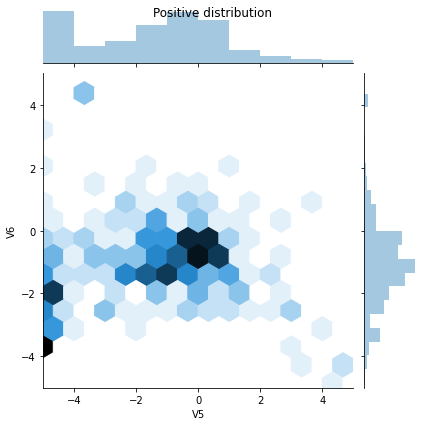

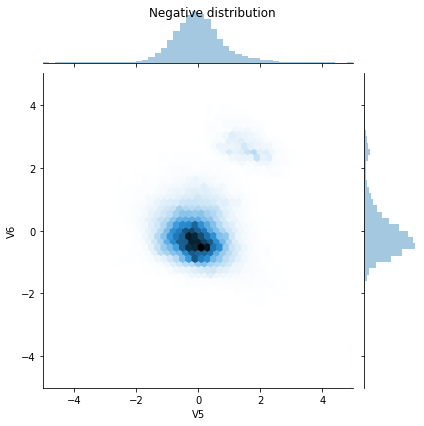

In [50]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
_ = plt.suptitle("Negative distribution")

# Define the model

Define a function that creates a simple neural network with a densly connected hidden layer, a dropout layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

## Metrics

Note: Accuracy is not a helpful metric for this task. You can 99.8%+ accuracy on this task by predicting False all the time.

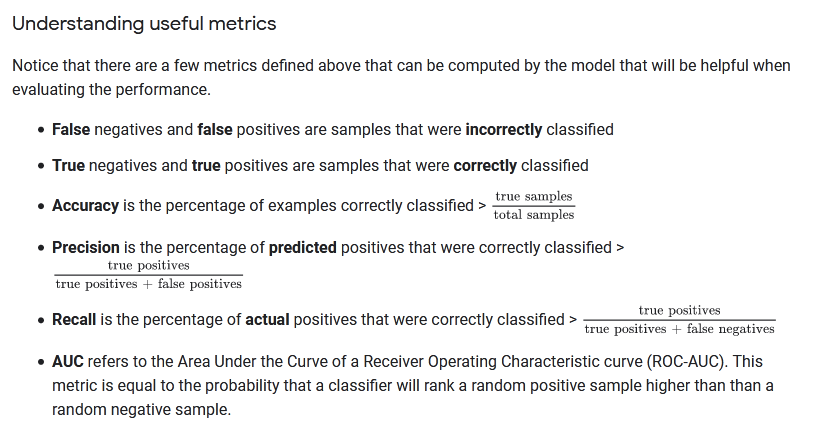

In [0]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [0]:
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    
    return model


Now create and train your model using the function that was defined earlier.

 Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. 
 
 If the batch size was too small, they would likely have no fraudulent transactions to learn from.

In [0]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [54]:
model = make_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16)                480       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


# Set the correct initial bias

In [55]:
# Let's test run the model
model.predict(train_features[:10])

array([[0.7050048 ],
       [0.564894  ],
       [0.7977926 ],
       [0.23069802],
       [0.7563945 ],
       [0.49492916],
       [0.4884014 ],
       [0.5551606 ],
       [0.32258534],
       [0.308377  ]], dtype=float32)

These are initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that (See: A Recipe for Training Neural Networks: "init well"). This can help with initial convergence.

With the default bias initialization the loss should be about math.log(2) = 0.69314

In [56]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.8296


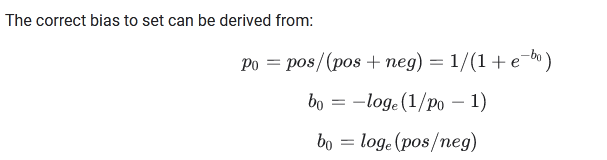

In [57]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

Set that as the initial bias, and the model will give much more reasonable initial guesses.

It should be near: pos/total = 0.0018

In [58]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.00199313],
       [0.00111159],
       [0.00676023],
       [0.00151257],
       [0.00136232],
       [0.00191386],
       [0.00275521],
       [0.00265163],
       [0.00186753],
       [0.00079072]], dtype=float32)

In [59]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0124


With this initialization the initial loss should be approximately:

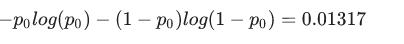


This initial loss is about 50 times less than if would have been with naive initilization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

# Checkpointing

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [0]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

# Confirm that bias fixing works

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [0]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [0]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [0]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

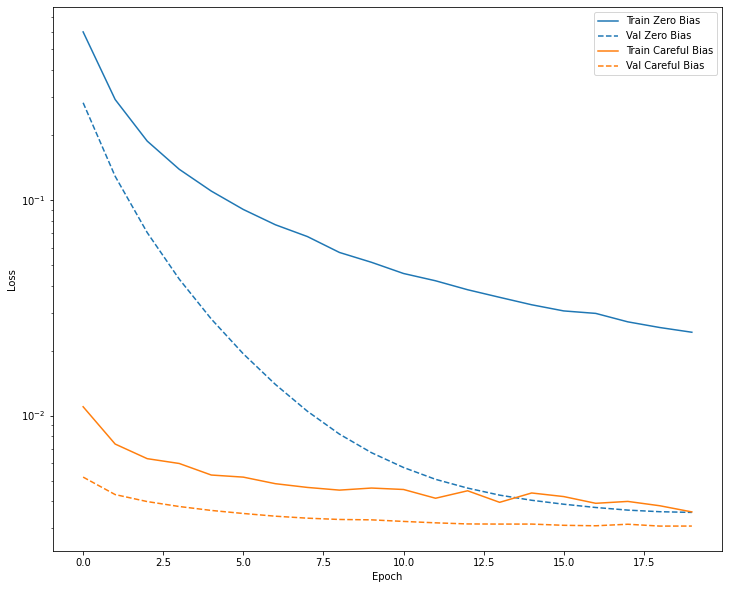

In [64]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage. 

# Train the correct model

In [65]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels), verbose=-1)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping


# Plot the results

In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in this tutorial.

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [0]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


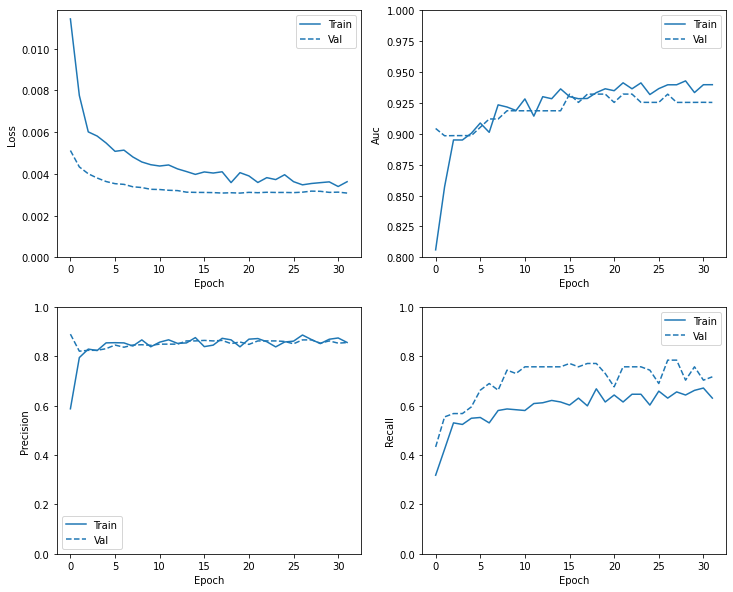

In [67]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

# Evaluate metrics

You can use a confusion matrix to summarize the actual vs. predicted labels where the X axis is the predicted label and the Y axis is the actual label.

In [0]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [0]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))


loss :  0.0030226055532693863
tp :  76.0
fp :  9.0
tn :  56854.0
fn :  23.0
accuracy :  0.9994382262229919
precision :  0.8941176533699036
recall :  0.7676767706871033
auc :  0.9340476393699646

Legitimate Transactions Detected (True Negatives):  56854
Legitimate Transactions Incorrectly Detected (False Positives):  9
Fraudulent Transactions Missed (False Negatives):  23
Fraudulent Transactions Detected (True Positives):  76
Total Fraudulent Transactions:  99


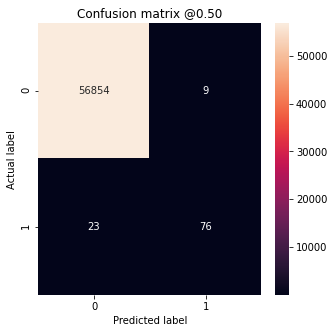

In [70]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

If the model had predicted everything perfectly, this would be a diagonal matrix where values off the main diagonal, indicating incorrect predictions, would be zero. 

n this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. 

This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

# Plot the ROC

Now plot the ROC. This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold

In [0]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')


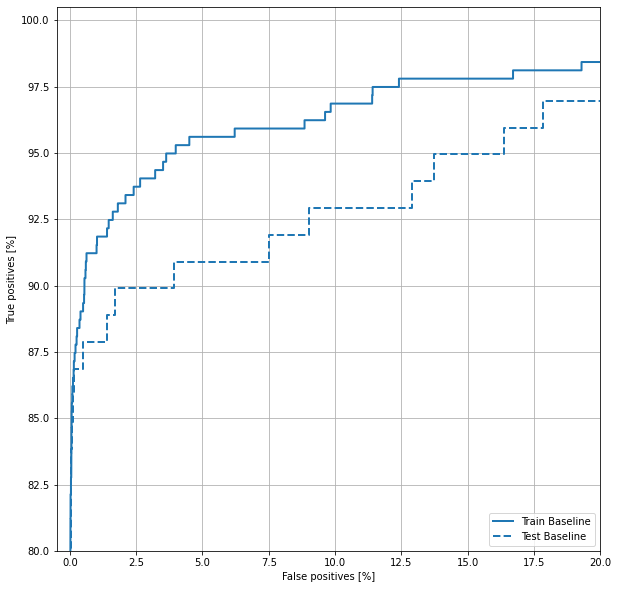

In [72]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. 

It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

# Improving the Model



## 1. Class Weights

The goal is to identify fradulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. 

You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [73]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


Note:

Using class_weights changes the range of the loss. 

This may affect the stability of the training depending on the optimizer. 

Optimizers whose step size is dependent on the magnitude of the gradient, like optimizers.SGD, may fail. 

The optimizer used here, optimizers.Adam, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [74]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight, verbose=-1) 

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping


## Plot metrics

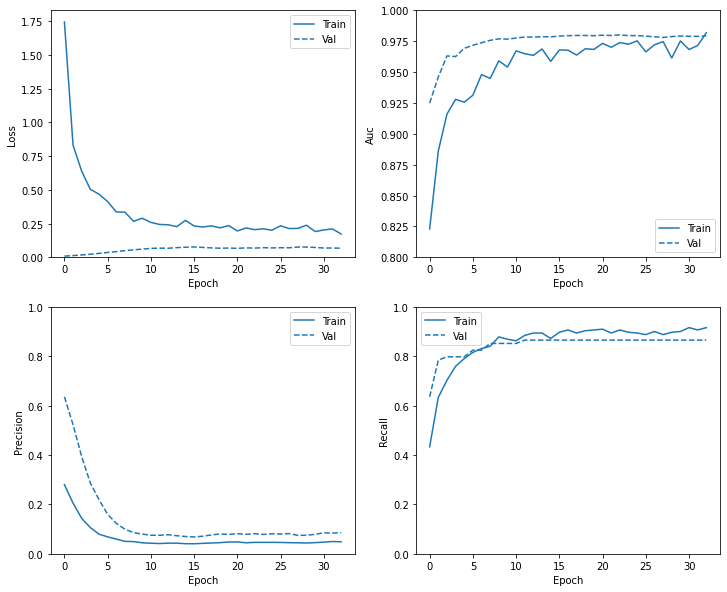

In [75]:
plot_metrics(weighted_history)

## Evaluate metrics

In [0]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.0673774853348732
tp :  87.0
fp :  835.0
tn :  56028.0
fn :  12.0
accuracy :  0.9851304292678833
precision :  0.09436008334159851
recall :  0.8787878751754761
auc :  0.9716066122055054

Legitimate Transactions Detected (True Negatives):  56028
Legitimate Transactions Incorrectly Detected (False Positives):  835
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  87
Total Fraudulent Transactions:  99


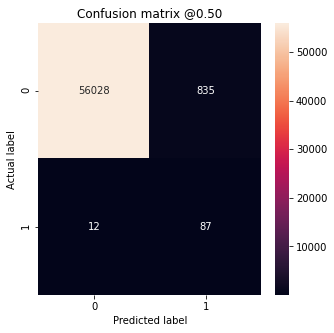

In [77]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. 

Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade offs between these different types of errors for your application.

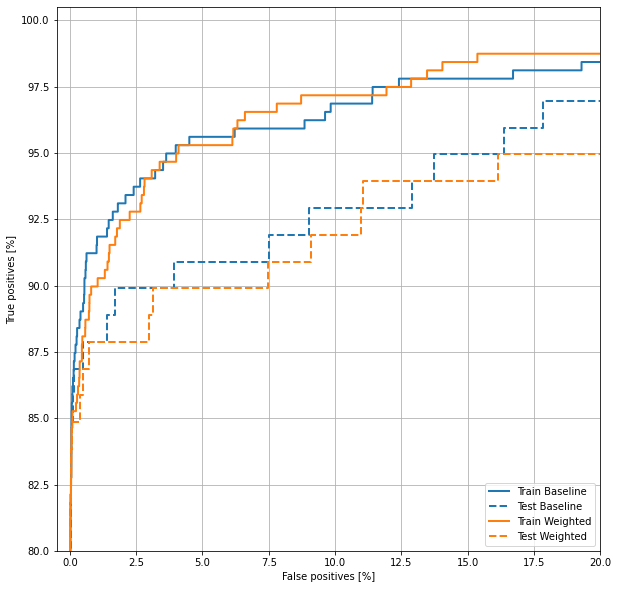

In [78]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right')

## Approach 2: OverSampling

Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [0]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

- Using NumPy

You can balance the dataset manually by choosing the right number of random indices from the positive examples:

In [80]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181957, 29)

In [81]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363914, 29)

Using tf.data

If you're using tf.data the easiest way to produce balanced examples is to start with a positive and a negative dataset, and merge them. See the tf.data guide for more examples.

In [0]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)


Merge the two together using experimental.sample_from_datasets:

In [0]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [84]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps. 

## Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

In [85]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)


Epoch 1/100
278/278 [==============================] - 9s 31ms/step - loss: 0.4044 - tp: 242527.0000 - fp: 66332.0000 - tn: 275497.0000 - fn: 41950.0000 - accuracy: 0.8271 - precision: 0.7852 - recall: 0.8525 - auc: 0.9173 - val_loss: 0.1910 - val_tp: 64.0000 - val_fp: 910.0000 - val_tn: 44585.0000 - val_fn: 10.0000 - val_accuracy: 0.9798 - val_precision: 0.0657 - val_recall: 0.8649 - val_auc: 0.9756
Epoch 2/100
278/278 [==============================] - 8s 29ms/step - loss: 0.1844 - tp: 259475.0000 - fp: 15330.0000 - tn: 269749.0000 - fn: 24790.0000 - accuracy: 0.9295 - precision: 0.9442 - recall: 0.9128 - auc: 0.9782 - val_loss: 0.1045 - val_tp: 64.0000 - val_fp: 723.0000 - val_tn: 44772.0000 - val_fn: 10.0000 - val_accuracy: 0.9839 - val_precision: 0.0813 - val_recall: 0.8649 - val_auc: 0.9747
Epoch 3/100
278/278 [==============================] - 8s 28ms/step - loss: 0.1446 - tp: 262830.0000 - fp: 9908.0000 - tn: 274658.0000 - fn: 21948.0000 - accuracy: 0.9440 - precision: 0.9637 -

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight.

This smoother gradient signal makes it easier to train the model.

# Plot oversampling results

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

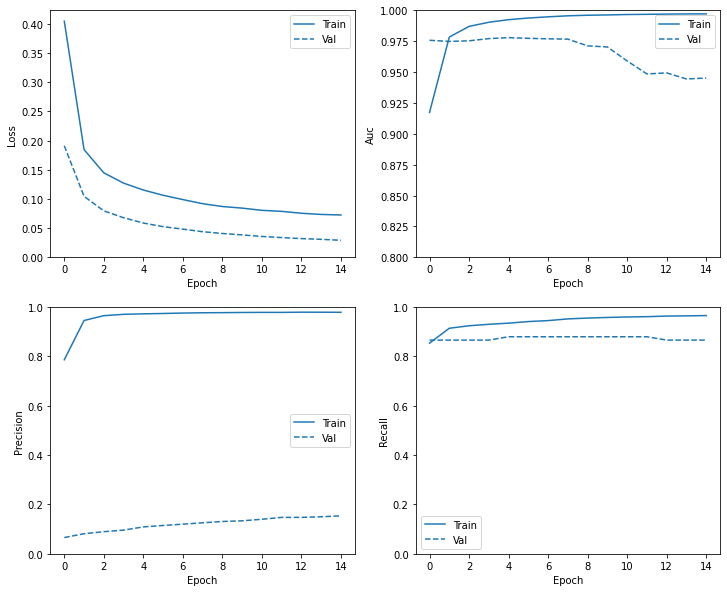

In [86]:
plot_metrics(resampled_history )

Re-train

Because training is easier on the balanced data, the above training procedure may overfit quickly.

So break up the epochs to give the callbacks.EarlyStopping finer control over when to stop training

In [87]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))


Epoch 1/1000
20/20 [==============================] - 2s 81ms/step - loss: 0.9075 - tp: 13647.0000 - fp: 10375.0000 - tn: 55640.0000 - fn: 6867.0000 - accuracy: 0.8007 - precision: 0.5681 - recall: 0.6653 - auc: 0.8732 - val_loss: 0.7686 - val_tp: 69.0000 - val_fp: 21187.0000 - val_tn: 24308.0000 - val_fn: 5.0000 - val_accuracy: 0.5349 - val_precision: 0.0032 - val_recall: 0.9324 - val_auc: 0.9192
Epoch 2/1000
20/20 [==============================] - 1s 40ms/step - loss: 0.6520 - tp: 15903.0000 - fp: 9116.0000 - tn: 11340.0000 - fn: 4601.0000 - accuracy: 0.6651 - precision: 0.6356 - recall: 0.7756 - auc: 0.7837 - val_loss: 0.6925 - val_tp: 70.0000 - val_fp: 17108.0000 - val_tn: 28387.0000 - val_fn: 4.0000 - val_accuracy: 0.6245 - val_precision: 0.0041 - val_recall: 0.9459 - val_auc: 0.9357
Epoch 3/1000
20/20 [==============================] - 1s 38ms/step - loss: 0.5514 - tp: 16773.0000 - fp: 7940.0000 - tn: 12550.0000 - fn: 3697.0000 - accuracy: 0.7159 - precision: 0.6787 - recall: 0.

In [0]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.1579568237066269
tp :  87.0
fp :  995.0
tn :  55868.0
fn :  12.0
accuracy :  0.982321560382843
precision :  0.08040665090084076
recall :  0.8787878751754761
auc :  0.9621785283088684

Legitimate Transactions Detected (True Negatives):  55868
Legitimate Transactions Incorrectly Detected (False Positives):  995
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  87
Total Fraudulent Transactions:  99


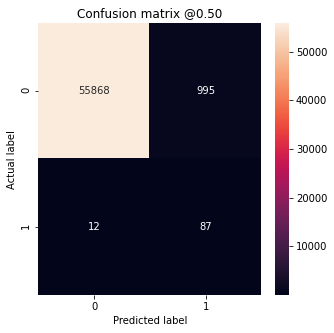

In [89]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)


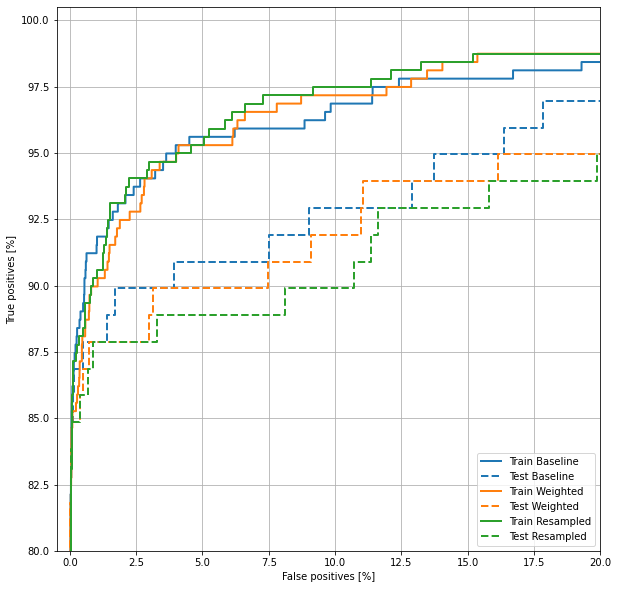

In [90]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')


# Applying this tutorial to your problem

Imbalanced data classification is an inherantly difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.